# pyLocusZoom - Getting Started

This notebook demonstrates the key features of pyLocusZoom for creating regional association plots.

**Requirements for interactive backends:** Interactive display of Plotly/Bokeh plots requires `nbformat>=4.2.0`. Run `%pip install nbformat` if needed.

In [1]:
# Install dependencies (uncomment if needed)
# %pip install pylocuszoom nbformat

In [2]:
import warnings
warnings.filterwarnings("ignore", message=".*FancyArrowPatch.*")

import numpy as np
import pandas as pd
from pylocuszoom import LocusZoomPlotter

## 1. Create Sample Data

First, let's create some synthetic GWAS and gene data for demonstration.

In [3]:
# Generate synthetic GWAS data
np.random.seed(42)
n_snps = 500
positions = np.sort(np.random.randint(1_000_000, 2_000_000, n_snps))

# Create a peak around position 1,500,000
p_values = np.ones(n_snps) * 0.5
peak_center = 1_500_000
for i, pos in enumerate(positions):
    dist = abs(pos - peak_center)
    if dist < 100_000:
        p_values[i] = 10 ** -(8 * np.exp(-dist / 30_000))
    else:
        p_values[i] = np.random.uniform(0.01, 1)

gwas_df = pd.DataFrame({
    'ps': positions,
    'p_wald': p_values,
    'rs': [f'rs{i}' for i in range(n_snps)],
})

print(f"GWAS data: {len(gwas_df)} SNPs")
gwas_df.head()

GWAS data: 500 SNPs


,ps,p_wald,rs
0,1002869,0.365060,rs0
1,1004014,0.261622,rs1
2,1008155,0.302338,rs2
3,1012666,0.329325,rs3
4,1013986,0.850183,rs4


In [4]:
# Create gene annotations
genes_df = pd.DataFrame({
    'chr': ['1', '1', '1', '1'],
    'start': [1_100_000, 1_400_000, 1_550_000, 1_800_000],
    'end': [1_200_000, 1_520_000, 1_650_000, 1_900_000],
    'gene_name': ['GENE1', 'GENE2', 'GENE3', 'GENE4'],
    'strand': ['+', '-', '+', '-'],
})

# Create exon annotations
exons_df = pd.DataFrame({
    'chr': ['1', '1', '1', '1', '1', '1'],
    'start': [1_100_000, 1_150_000, 1_400_000, 1_450_000, 1_550_000, 1_600_000],
    'end': [1_120_000, 1_170_000, 1_420_000, 1_470_000, 1_580_000, 1_630_000],
    'gene_name': ['GENE1', 'GENE1', 'GENE2', 'GENE2', 'GENE3', 'GENE3'],
})

print("Genes:")
genes_df

Genes:


,chr,start,end,gene_name,strand
0,1,1100000,1200000,GENE1,+
1,1,1400000,1520000,GENE2,-
2,1,1550000,1650000,GENE3,+
3,1,1800000,1900000,GENE4,-


## 2. Basic Plot (Matplotlib)

Create a basic regional association plot using the default matplotlib backend.

In [ ]:
# Initialize plotter (default: matplotlib backend)
# genomewide_threshold defaults to 5e-8; override for species-specific thresholds
plotter = LocusZoomPlotter(
    species="canine",
    genomewide_threshold=5e-8,  # Standard GWAS significance (red dashed line)
    log_level=None,
)

# Create plot
fig = plotter.plot(
    gwas_df,
    chrom=1,
    start=1_000_000,
    end=2_000_000,
    lead_pos=1_500_000,
    genes_df=genes_df,
    exons_df=exons_df,
    show_recombination=False,  # Disable for demo
    snp_labels=True,
    label_top_n=3,
)

# Display in notebook (matplotlib figures display automatically)
fig

## 3. Interactive Backends

pyLocusZoom supports three rendering backends:
- **matplotlib** (default) - Static publication-quality plots
- **plotly** - Interactive plots with hover tooltips
- **bokeh** - Dashboard-ready interactive plots

In [6]:
# Plotly backend - interactive with hover tooltips and LD coloring
from IPython.display import display, HTML

# Add fake LD data (R² values based on distance from lead SNP)
gwas_with_ld = gwas_df.copy()
lead_position = 1_500_000
gwas_with_ld['R2'] = np.exp(-abs(gwas_with_ld['ps'] - lead_position) / 50_000)
gwas_with_ld.loc[gwas_with_ld['R2'] < 0.1, 'R2'] = np.random.uniform(0, 0.2, (gwas_with_ld['R2'] < 0.1).sum())

plotter_plotly = LocusZoomPlotter(
    species="canine",
    backend="plotly",
    log_level=None,
)

fig_plotly = plotter_plotly.plot(
    gwas_with_ld,
    chrom=1,
    start=1_000_000,
    end=2_000_000,
    lead_pos=lead_position,
    ld_col="R2",  # Use pre-computed LD
    show_recombination=False,
    figsize=(8, 4),  # 25% larger figure for notebook display
)

# Display inline using HTML injection (works in all notebooks including Databricks)
display(HTML(fig_plotly.to_html(include_plotlyjs='cdn')))

In [7]:
# Bokeh backend - interactive with hover tooltips and LD coloring
from bokeh.resources import CDN
from bokeh.embed import file_html
from IPython.display import display, HTML

plotter_bokeh = LocusZoomPlotter(
    species="canine",
    backend="bokeh",
    log_level=None,
)

# Reuse the same GWAS data with LD from above
fig_bokeh = plotter_bokeh.plot(
    gwas_with_ld,
    chrom=1,
    start=1_000_000,
    end=2_000_000,
    lead_pos=lead_position,
    ld_col="R2",  # Use pre-computed LD for coloring
    show_recombination=False,
    figsize=(8, 4),  # 25% larger figure for notebook display
)

# Display inline using HTML injection (works in all notebooks including Databricks)
display(HTML(file_html(fig_bokeh, CDN, "pyLocusZoom - Bokeh with LD")))

## 4. Stacked Plots

Compare multiple GWAS results (e.g., different phenotypes) in a stacked layout.

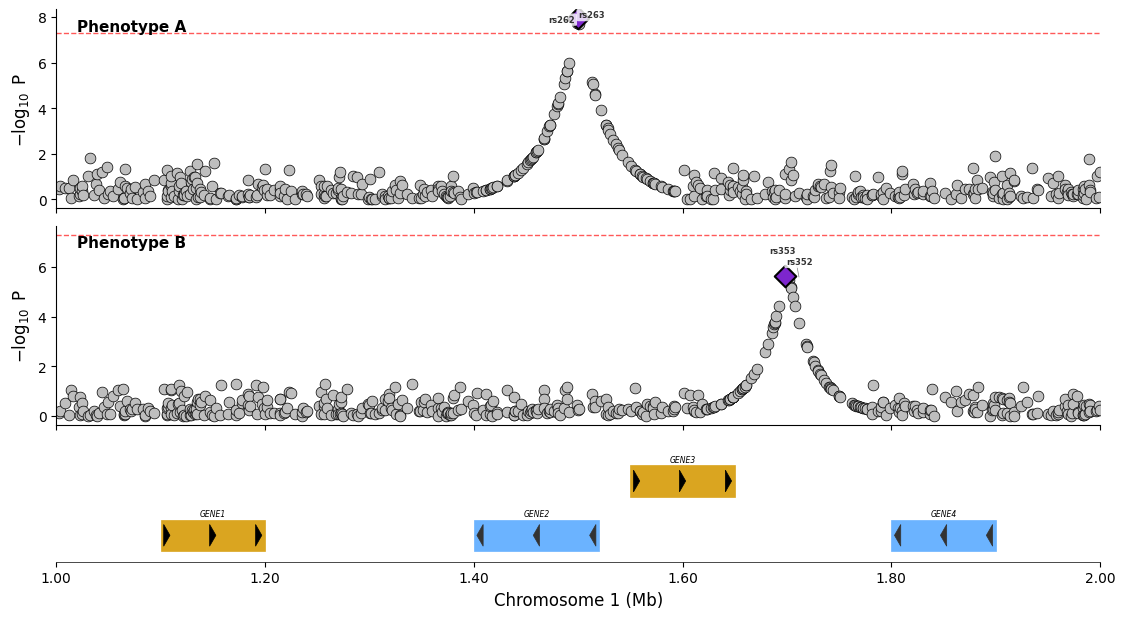

In [8]:
# Create a second GWAS with different peak
gwas_df2 = gwas_df.copy()
gwas_df2['p_wald'] = np.ones(n_snps) * 0.5
peak_center2 = 1_700_000
for i, pos in enumerate(positions):
    dist = abs(pos - peak_center2)
    if dist < 80_000:
        gwas_df2.loc[i, 'p_wald'] = 10 ** -(6 * np.exp(-dist / 25_000))
    else:
        gwas_df2.loc[i, 'p_wald'] = np.random.uniform(0.05, 1)

# Create stacked plot
plotter = LocusZoomPlotter(species="canine", log_level=None)

fig = plotter.plot_stacked(
    [gwas_df, gwas_df2],
    chrom=1,
    start=1_000_000,
    end=2_000_000,
    panel_labels=["Phenotype A", "Phenotype B"],
    genes_df=genes_df,
    show_recombination=False,
    label_top_n=2,
)

fig

### Stacked Plots with Interactive Backends

The `plot_stacked()` method works with all backends. Here are Plotly and Bokeh versions with hover tooltips.

In [9]:
# Plotly stacked plot - compare two phenotypes interactively
from IPython.display import display, HTML

# Add fake LD data to both datasets
gwas1_with_ld = gwas_df.copy()
gwas1_with_ld['R2'] = np.exp(-abs(gwas1_with_ld['ps'] - 1_500_000) / 50_000)
gwas1_with_ld.loc[gwas1_with_ld['R2'] < 0.1, 'R2'] = np.random.uniform(0, 0.2, (gwas1_with_ld['R2'] < 0.1).sum())

gwas2_with_ld = gwas_df2.copy()
gwas2_with_ld['R2'] = np.exp(-abs(gwas2_with_ld['ps'] - 1_700_000) / 50_000)
gwas2_with_ld.loc[gwas2_with_ld['R2'] < 0.1, 'R2'] = np.random.uniform(0, 0.2, (gwas2_with_ld['R2'] < 0.1).sum())

plotter_plotly = LocusZoomPlotter(species="canine", backend="plotly", log_level=None)

fig_stacked_plotly = plotter_plotly.plot_stacked(
    [gwas1_with_ld, gwas2_with_ld],
    chrom=1,
    start=1_000_000,
    end=2_000_000,
    panel_labels=["Phenotype A", "Phenotype B"],
    lead_positions=[1_500_000, 1_700_000],  # Different lead SNP per panel
    ld_col="R2",
    show_recombination=False,
    snp_labels=False,  # SNP labels not yet supported in Plotly
    figsize=(8, 7),  # Taller figure for stacked panels
)

display(HTML(fig_stacked_plotly.to_html(include_plotlyjs='cdn')))

In [10]:
# Bokeh stacked plot - compare two phenotypes interactively
from bokeh.resources import CDN
from bokeh.embed import file_html
from IPython.display import display, HTML

plotter_bokeh = LocusZoomPlotter(species="canine", backend="bokeh", log_level=None)

# Reuse the LD-annotated data from above
fig_stacked_bokeh = plotter_bokeh.plot_stacked(
    [gwas1_with_ld, gwas2_with_ld],
    chrom=1,
    start=1_000_000,
    end=2_000_000,
    panel_labels=["Phenotype A", "Phenotype B"],
    lead_positions=[1_500_000, 1_700_000],
    ld_col="R2",
    show_recombination=False,
    snp_labels=False,  # SNP labels not yet supported in Bokeh
    figsize=(8, 7),  # Taller figure for stacked panels
)

display(HTML(file_html(fig_stacked_bokeh, CDN, "pyLocusZoom - Bokeh Stacked")))

## 5. eQTL Overlay

Add expression QTL data as a separate panel to compare GWAS and eQTL signals.

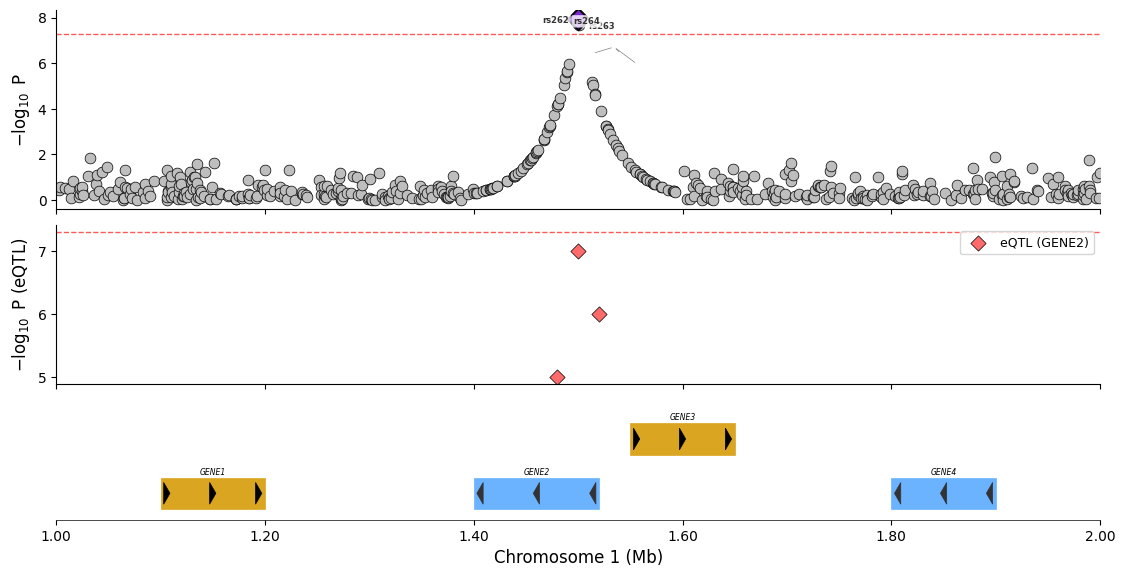

In [11]:
# Create synthetic eQTL data
eqtl_df = pd.DataFrame({
    'pos': [1_480_000, 1_500_000, 1_520_000, 1_550_000, 1_600_000],
    'p_value': [1e-5, 1e-7, 1e-6, 1e-4, 0.01],
    'gene': ['GENE2', 'GENE2', 'GENE2', 'GENE3', 'GENE3'],
})

# Create plot with eQTL panel
fig = plotter.plot_stacked(
    [gwas_df],
    chrom=1,
    start=1_000_000,
    end=2_000_000,
    eqtl_df=eqtl_df,
    eqtl_gene="GENE2",
    genes_df=genes_df,
    show_recombination=False,
)

fig

## 5b. Fine-mapping Visualization

Visualize fine-mapping results (e.g., SuSiE) with credible set coloring. Fine-mapping uses `plot_stacked()` with the `finemapping_df` parameter. Points are colored by their credible set membership.

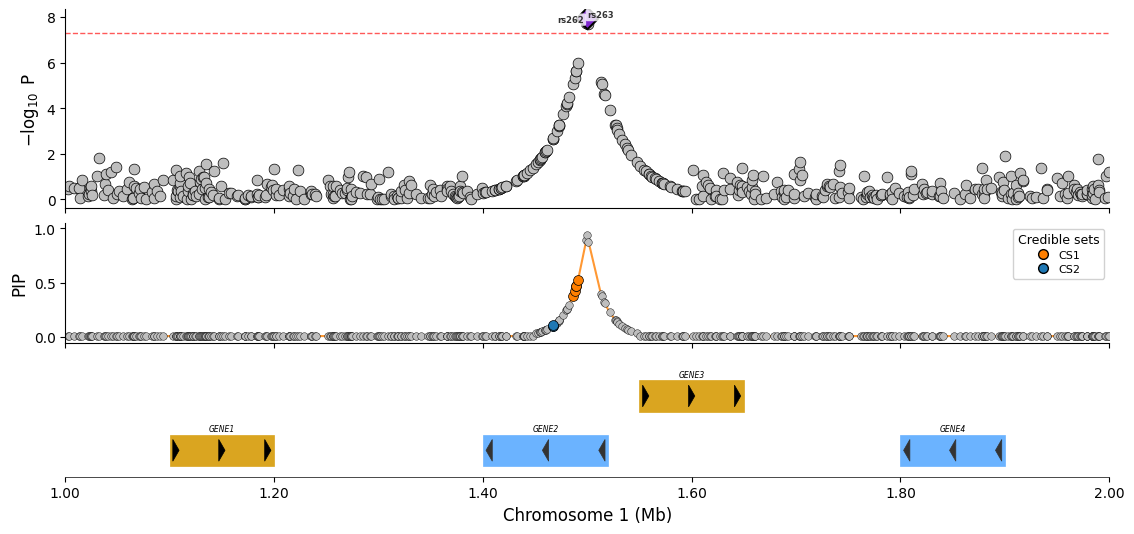

In [12]:
# Create synthetic fine-mapping data with PIP and credible sets
finemapping_df = gwas_df.copy()

# Rename ps to pos for fine-mapping API
finemapping_df = finemapping_df.rename(columns={'ps': 'pos'})

# Add posterior inclusion probabilities (PIP) - high near peak
finemapping_df['pip'] = 0.01
peak_snps = finemapping_df[abs(finemapping_df['pos'] - 1_500_000) < 50_000].index
for idx in peak_snps:
    dist = abs(finemapping_df.loc[idx, 'pos'] - 1_500_000)
    finemapping_df.loc[idx, 'pip'] = max(0.01, 0.95 * np.exp(-dist / 15_000))

# Assign credible sets (1 = primary, 2 = secondary, None = not in any)
finemapping_df['cs'] = None
cs1_snps = finemapping_df[finemapping_df['pip'] > 0.3].index[:5]
cs2_snps = finemapping_df[(finemapping_df['pip'] > 0.1) & (finemapping_df['pip'] <= 0.3)].index[:3]
finemapping_df.loc[cs1_snps, 'cs'] = 1
finemapping_df.loc[cs2_snps, 'cs'] = 2

# Create fine-mapping plot using plot_stacked with finemapping_df
# Points are colored by credible set (CS1=blue, CS2=orange), size scales with PIP
fig = plotter.plot_stacked(
    [gwas_df],  # GWAS data (can be empty list if only showing fine-mapping)
    chrom=1,
    start=1_000_000,
    end=2_000_000,
    finemapping_df=finemapping_df,
    finemapping_cs_col='cs',
    genes_df=genes_df,
    show_recombination=False,
    label_top_n=2,
)

fig

## 6. Saving Plots

Save plots to various formats.

In [13]:
# Matplotlib: save to PNG, PDF, SVG
plotter = LocusZoomPlotter(species="canine", log_level=None)
fig = plotter.plot(gwas_df, chrom=1, start=1_000_000, end=2_000_000, show_recombination=False)

# Save to temp files (avoid overwriting README examples)
fig.savefig("/tmp/my_plot.png", dpi=150, bbox_inches='tight')
fig.savefig("/tmp/my_plot.pdf", bbox_inches='tight')
print("Saved: /tmp/my_plot.png, /tmp/my_plot.pdf")

# Plotly: save to HTML
# fig_plotly.write_html("/tmp/my_plot_interactive.html")

# Bokeh: save to HTML
# from bokeh.io import save
# save(fig_bokeh, filename="/tmp/my_plot_bokeh.html")

Saved: /tmp/my_plot.png, /tmp/my_plot.pdf


## 7. Species Options

pyLocusZoom supports canine (*Canis lupus familiaris*), feline (*Felis catus*), and custom species.

In [14]:
# Canine (default) - has built-in recombination maps
plotter_canine = LocusZoomPlotter(species="canine")

# Canine with CanFam4 genome build (auto-liftover of recomb coords)
plotter_canfam4 = LocusZoomPlotter(species="canine", genome_build="canfam4")

# Feline - LD and gene tracks (user provides recombination data)
plotter_feline = LocusZoomPlotter(species="feline")

# Custom species (e.g., human) - provide all reference data yourself
plotter_human = LocusZoomPlotter(species=None)

print("Species configurations created successfully!")

Species configurations created successfully!


## 7b. Human Example with UCSC Gene Annotations

For human GWAS, you can fetch gene annotations from UCSC or other sources. Here's a complete example using the UCSC Table Browser API.

Key HLA genes:
  gene_name     start       end strand
0     HLA-A  29942470  29945884      -
1     HLA-B  31268749  31272130      +
2     HLA-C  31353872  31357179      -
3   HLA-DRA  32439887  32445046      +
4  HLA-DQB1  32578769  32589848      +
5  HLA-DQA1  32637406  32654846      -


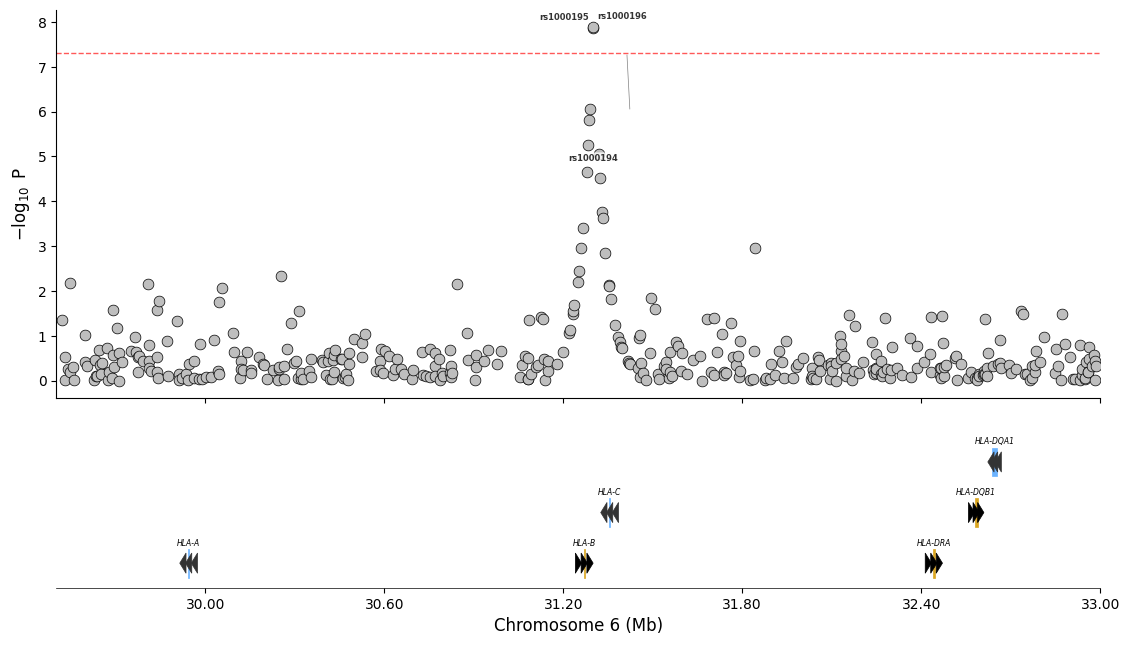

In [15]:
# Human GWAS Example - MHC region (chr6:29-33Mb)
# This region is gene-dense, so we curate a list of key HLA genes

# Curated HLA gene coordinates (GRCh38)
human_genes = pd.DataFrame({
    "chr": ["6", "6", "6", "6", "6", "6"],
    "start": [29_942_470, 31_268_749, 31_353_872, 32_439_887, 32_578_769, 32_637_406],
    "end": [29_945_884, 31_272_130, 31_357_179, 32_445_046, 32_589_848, 32_654_846],
    "gene_name": ["HLA-A", "HLA-B", "HLA-C", "HLA-DRA", "HLA-DQB1", "HLA-DQA1"],
    "strand": ["-", "+", "-", "+", "+", "-"],
})

print("Key HLA genes:")
print(human_genes[["gene_name", "start", "end", "strand"]])

# Create synthetic human GWAS data with peak near HLA-B/C
np.random.seed(123)
human_positions = np.sort(np.random.randint(29_500_000, 33_000_000, 400))
human_pvals = np.random.uniform(0.001, 1, 400)

# Add a peak near HLA-B (31.3Mb)
for i, pos in enumerate(human_positions):
    if abs(pos - 31_300_000) < 150_000:
        human_pvals[i] = 10 ** -(8 * np.exp(-abs(pos - 31_300_000) / 40_000))

human_gwas = pd.DataFrame({
    "pos": human_positions,
    "pval": human_pvals,
    "rsid": [f"rs{1000000 + i}" for i in range(400)],
})

# Plot human GWAS with custom species (species=None)
plotter_human = LocusZoomPlotter(species=None, log_level=None)

fig = plotter_human.plot(
    human_gwas,
    chrom=6,
    start=29_500_000,
    end=33_000_000,
    pos_col="pos",
    p_col="pval",
    rs_col="rsid",
    genes_df=human_genes,
    show_recombination=False,
    snp_labels=True,
    label_top_n=3,
)

fig

## Summary

pyLocusZoom provides:

- **Static plots**: Publication-quality matplotlib figures ✓
- **Interactive plots**: Plotly and Bokeh backends ✓
- **Stacked plots**: Compare multiple GWAS/phenotypes ✓
- **eQTL overlay**: Expression QTL data integration ✓
- **Fine-mapping**: SuSiE/credible set visualization ✓
- **Species support**: Canine, feline, or custom species ✓
- **PySpark support**: Handle large-scale genomics data ✓

For more details, see the [documentation](https://github.com/michael-denyer/pyLocusZoom).